<a href="https://colab.research.google.com/github/qiuyu-jia/20027797/blob/main/LSTMsForHumanMotion1_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity: Build an LSTM to build a classifier for the Human Activity Recognition Using Smartphones Dataset #

Adapted from https://github.com/servomac/Human-Activity-Recognition/

Dataset information at https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones#





In [2]:
#All our imports
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

In [1]:
!pip install tensorflow 
!pip install tensorflow_datasets

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [3]:
pip install matplotlib 


In [ ]:
#If you run into any errors running the cell above, you may need to install a package using !pip install ...

In [4]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f12a898e1a2a310cb400c9ac463e87b8864b0f9a220a46228294d9a02be2c83d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


downloading
done


In [36]:
# This is helper code from the github repo.
#No need to edit this, but it's helpful to glance through this code to see what it does

DATADIR = 'UCI HAR Dataset' 

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test


def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

def _count_classes(y):
    return len(set([tuple(category) for category in y]))

## Our LSTM model ##

This is where the important stuff happens. Try to understand everything happening here, and experiment with changing it once you've got the basic method working.


In [37]:
#Load the data and splits into training and test sets, where X is input and Y is output
X_train, X_test, Y_train, Y_test = load_data()

#Compute some information from the data, which we need to set up the model
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

In [19]:
#After loading data, it's always a good idea to get a feel for what is in the data 

#For instance, we can use np.shape() to look at the shape of our examples
print(np.shape(X_train)) #this shows us we have 7352 training examples, where each input is 128x9 (9 channels of 128 samples each)

(7352, 128, 9)


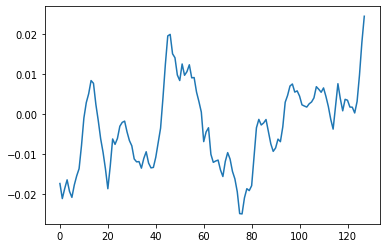

In [40]:
#We can peek at an individual example
exampleNumber = 5
channelNumber = 5
plot(np.transpose(X_train[exampleNumber])[channelNumber])

In [41]:
print(np.shape(Y_train)) #and we have a 6-dimensional output for each one of our 7352 examples

(7352, 6)


In [42]:
#We're using a "one-hot" encoding, which means that "1 0 0 0 0 0" means "class 1", "0 1 0 0 0 0" means class 2, and so on
print(Y_train[0]) #Prints the 6-dimensional output for the first training example

[0 0 0 0 1 0]


In [43]:
# This is where things get fun.

# Set some parameters to control training
# The number of epochs is the number of passes through the training data to make before you stop training
epochs = 5 # Play with this; might especially want to increase it once you know things are basically working

# The batch size is the number of examples to use to compute the gradient before updating the weights
# If batch_size is the same as the training set size, we use the whole training set every time. This is called "batch gradient descent"
# If batch_size is 1 then this is "stochastic gradient descent"
# If batch_size is something in between, then this is called "mini-batch" gradient descent
# Each choice will have different tradeoffs in terms of training time and ultimate accuracy, but there's no "right way" to do it
# For more info, see https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20batch%20size%20is%20a%20hyperparameter%20that%20defines%20the%20number,updating%20the%20internal%20model%20parameters.&text=When%20the%20batch%20size%20is,called%20mini%2Dbatch%20gradient%20descent. 
batch_size = 16 #You might want to play with this too

#How many hidden neurons do we want?
n_hidden = 32 #Feel free to change this


#This is the Keras code for specifying the network architecture:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.1)) #This is a method to try to prevent overfitting. See more at https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
model.add(Dense(n_classes, activation='sigmoid')) #a plain "dense" layer comes after the LSTM layer

#This line specifies how to train this network.
#You might want to play with these 3 values
#see more at https://keras.io/api/losses/, https://keras.io/api/optimizers/, https://keras.io/api/metrics/
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

#This line of code actually trains the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Evaluate the model on the test data
print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/5
460/460 [==============================] - 25s 49ms/step - loss: 1.2167 - accuracy: 0.5000 - val_loss: 1.1508 - val_accuracy: 0.4910
Epoch 2/5
460/460 [==============================] - 22s 49ms/step - loss: 0.8449 - accuracy: 0.6532 - val_loss: 0.8072 - val_accuracy: 0.7116
Epoch 3/5
460/460 [==============================] - 23s 50ms/step - loss: 0.6102 - accuracy: 0.7497 - val_loss: 0.6517 - val_accuracy: 0.7557
Epoch 4/5
460/460 [==============================] - 24s 53ms/step - loss: 0.4092 - accuracy: 0.8331 - val_loss: 0.5731 - val_accuracy: 0.7988
Epoch 5/5
460/460 [==============================] - 23s 50ms/step - loss: 0.3376 - accuracy: 0.8717 - val_loss: 0.5020 - val_accuracy: 0.8487
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        26        0                   0   
SITTING                  0      386        93      

## Next steps: Experiment!

### 1. Try digging into & tweaking the results above. ###

* What happens with a different optimizer?
* Can you edit the code to use a validation set with early stopping, as well?
* What happens to the training accuracy, test/validation accuracy, and training time if you change the number of training examples?
* What happens if you change the dropout?
* Can you visualise this data (e.g., in Python using matplotlib, or in Excel) to get a sense of what it looks like?
* What else might you print each epoch, instead of just accuracy and loss?
* What else might you do if you were trying to release a commercial product that did this classification? How would you test it? How else might you edit the code to train your neural network? What would your main considerations be in deploying it?

### 2. Do more reading about all the options available to you in Keras ###
* https://keras.io/api/optimizers/
* https://keras.io/api/metrics/
* https://keras.io/api/losses/
* Use the `?` operation in Python to learn more about your options in code (e.g., `?model.compile`)


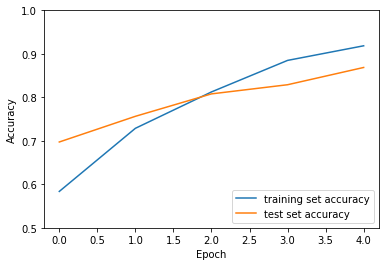

In [ ]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')